In [1]:
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
import keras
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout
from keras import layers
import numpy as np
from keras.callbacks import EarlyStopping
from tensorflow import nn
from sklearn.preprocessing import normalize
from glob import glob
import os

In [2]:
path = "W:\Advanced Engineering\Vortex Ballistics\Gel Images\Model Training"
HEIGHT = 384*4
WIDTH = 576*4
trainFile = '03- train- Img only'
testFile = '04- test- Img only'
BATCH_SIZE = 32

[[  7  11  24 ...  25  10   7]
 [ 10 145 150 ... 150 143  10]
 [ 24 154 142 ... 143 155  27]
 ...
 [ 24 154 142 ... 143 155  27]
 [ 10 145 150 ... 150 143  10]
 [  7  11  24 ...  25  10   7]]


(384, 576)

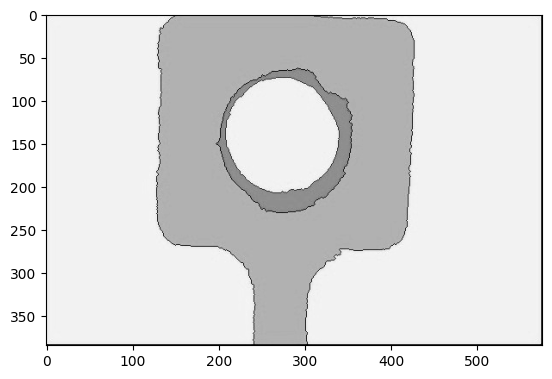

In [3]:
# file = "W:\Advanced Engineering\Vortex Ballistics\Gel Images\Model Training\\train\Outputs\img\IMG_0467_blurred.JPG"
# img = cv2.imread(file)
# plt.imshow(img)
# img.shape

file = "W:\Advanced Engineering\Vortex Ballistics\Gel Images\Model Training/03- train- Img only\Watershed Out\img\IMG_00074.jpg"
img = cv2.imread(file, 0)
print(img)
plt.imshow(img, cmap='gray')
img.shape[:]

In [4]:
seed = 42
BATCH_SIZE = 32
inputDataGen2 = ImageDataGenerator(rescale=1./255,
                                  horizontal_flip=True,
                                  width_shift_range=0.1,
                                  zoom_range=0.2,
                                  fill_mode='nearest',
                                  )
#inputDataGen = ImageDataGenerator(rescale=1./255)

# inGen = inputDataGen.flow_from_directory(path + '\\01- train\\Input', batch_size=32, class_mode=None, seed=seed, color_mode='grayscale')
# outGen = inputDataGen.flow_from_directory(path + '\\01- train\\Ring Mask', batch_size=32, class_mode=None, seed=seed, color_mode='grayscale')
inGen = inputDataGen2.flow_from_directory(path + '\\03- train- Img only\\Input', batch_size=BATCH_SIZE, target_size=(HEIGHT, WIDTH), class_mode=None, seed=seed, color_mode='grayscale')
outGen = inputDataGen2.flow_from_directory(path + '\\03- train- Img only\\Ring Mask', batch_size=BATCH_SIZE, target_size=(HEIGHT, WIDTH), class_mode=None, seed=seed, color_mode='grayscale')

sampleSize = inGen.samples

train_generator = zip(inGen, outGen)

Found 583 images belonging to 1 classes.
Found 583 images belonging to 1 classes.


In [5]:
# inGen = outputDataGen.flow_from_directory(path + '\\02- test\\Input', batch_size=32, class_mode=None, seed=seed, color_mode='grayscale')
# outGen = outputDataGen.flow_from_directory(path + '\\02- test\\Ring Mask', batch_size=32, class_mode=None, seed=seed, color_mode="grayscale")
inGen = inputDataGen2.flow_from_directory(path + '\\04- test- Img only\\Input', batch_size=BATCH_SIZE, target_size=(HEIGHT, WIDTH), class_mode=None, seed=seed, color_mode='grayscale')
outGen = inputDataGen2.flow_from_directory(path + '\\04- test- Img only\\Ring Mask', batch_size=BATCH_SIZE, target_size=(HEIGHT, WIDTH), class_mode=None, seed=seed, color_mode="grayscale")

test_generator = zip(inGen, outGen)

Found 198 images belonging to 1 classes.
Found 198 images belonging to 1 classes.


In [6]:
def double_conv_block(x, out_channels):
    x = layers.Conv2D(filters= out_channels, kernel_size=3, strides=1, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(filters= out_channels, kernel_size=3, strides=1, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    return x 

In [7]:
def downsample_block(x, out_channels):
    f = double_conv_block(x, out_channels)
    p = layers.MaxPool2D(pool_size=2, strides=2)(f)
    p = layers.Dropout(0.5)(p)
    return f, p

In [8]:
def upsample_block(x, conv_features, out_channels):
    x = layers.Conv2DTranspose(filters = out_channels, kernel_size=2, strides=2, padding='same')(x)
    x = layers.concatenate(inputs=[x, conv_features], axis=3)
    x = layers.Dropout(0.5)(x)
    x = double_conv_block(x, out_channels)
    return x

In [9]:
def build_unet_model():
    inputs = layers.Input(shape=(HEIGHT, WIDTH, 1))
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = layers.MaxPool2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = layers.MaxPool2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = layers.MaxPool2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = layers.MaxPool2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(layers.UpSampling2D(size = (2,2))(drop5))
    merge6 = layers.concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(layers.UpSampling2D(size = (2,2))(conv6))
    merge7 = layers.concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(layers.UpSampling2D(size = (2,2))(conv7))
    merge8 = layers.concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(layers.UpSampling2D(size = (2,2))(conv8))
    merge9 = layers.concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = tf.keras.Model(inputs, conv10)
    return model



In [10]:
class OutputPrinting(keras.callbacks.Callback):
    testFile1 = "W:\Advanced Engineering\Vortex Ballistics\Gel Images\Model Training/00- Full Image Dataset\IMG_00703.JPG"
    testFile2 = "W:\Advanced Engineering\Vortex Ballistics\Gel Images\Model Training/00- Full Image Dataset\IMG_00827.JPG"
    testFile3 = "W:\Advanced Engineering\Vortex Ballistics\Gel Images\Model Training/00- Full Image Dataset\IMG_003.JPG"
    imgArr = [testFile1, testFile2, testFile3]
    
    def on_epoch_end(self, batch, logs=None):
        keys = list(logs.keys())
        
        fig = plt.figure(figsize=(3,2))

        for i in range(len(self.imgArr)):
            testImg = image.load_img(self.imgArr[i], color_mode='grayscale')
            testImg = np.expand_dims(testImg, axis=0)
            testImg = testImg/255
            imOut = self.model.predict(testImg)
            imOut = imOut.reshape(testImg.shape[1:3])
            testImg = testImg.reshape(testImg.shape[1:3])
            plt.subplot(3, 2, 2*i+1)
            plt.imshow(testImg, cmap='gray')
            plt.subplot(3, 2, 2*i+2)
            plt.imshow(imOut, cmap='gray')
            plt.axis('off')

        plt.show()

In [11]:
class EarlyStoppingAtMinLoss(keras.callbacks.Callback):

    def __init__(self, patience=100):
        super().__init__()
        self.patience = patience
        # best_weights to store the weights at which the minimum loss occurs.
        self.best_weights = None
        self.model_location = "W:\Advanced Engineering\Vortex Ballistics\~ACTIVE\Python Script\models\model 10-27_Ring Mask-105 epochs-582 images"

    def on_train_begin(self, logs=None):
        # The number of epoch it has waited when loss is no longer minimum.
        self.wait = 0
        # The epoch the training stops at.
        self.stopped_epoch = 0
        # Initialize the best as infinity.
        self.best = np.Inf

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get("val_loss")
        self.model.save(self.model_location + '/' + str(epoch) + '.h5')
        if np.less(current, self.best):
            self.best = current
            self.wait = 0
            # Record the best weights if current results is better (less).
            self.best_weights = self.model.get_weights()    
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped_epoch = epoch
                self.model.stop_training = True
                print("Restoring model weights from the end of the best epoch.")
                self.model.set_weights(self.best_weights)
        if current < 0.023:
            tf.keras.backend.set_value(self.model.optimizer.lr, 1e-6)
            print("\nEpoch %05d: Learning rate is %6.8f." % (epoch, 1e-6))
        if current < 0.015:
            tf.keras.backend.set_value(self.model.optimizer.lr, 1e-8)
            print("\nEpoch %05d: Learning rate is %6.8f." % (epoch, 1e-8))

    def on_train_end(self, logs=None):
        if self.stopped_epoch > 0:
            print("Epoch %05d: early stopping" % (self.stopped_epoch + 1))

In [12]:
unet_model = build_unet_model()
unet_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 1536, 2304, 1)]      0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 1536, 2304, 64)       640       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 1536, 2304, 64)       36928     ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 768, 1152, 64)        0         ['conv2d_1[0][0]']            
 D)                                                                                           

In [41]:
unet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                   loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                   #loss = 'mse',
                   metrics=["accuracy"])

es = EarlyStopping(monitor='val_loss', mode='min', patience=3, verbose=1, restore_best_weights=False)

Epoch 1/110
1/1 [==============================] - 1s 878ms/step


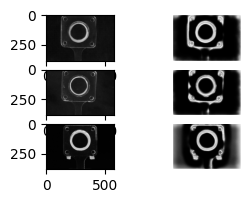

18/18 [==============================] - 2528s 141s/step - loss: 0.2622 - accuracy: 0.9583 - val_loss: 0.1095 - val_accuracy: 0.9587
Epoch 2/110
1/1 [==============================] - 1s 881ms/step


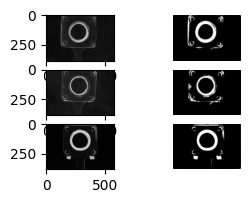

18/18 [==============================] - 1973s 115s/step - loss: 0.0314 - accuracy: 0.9577 - val_loss: 0.0536 - val_accuracy: 0.9576
Epoch 3/110
1/1 [==============================] - 1s 902ms/step


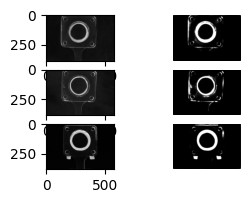

18/18 [==============================] - 2097s 117s/step - loss: 0.0243 - accuracy: 0.9579 - val_loss: 0.0544 - val_accuracy: 0.9576
Epoch 4/110
1/1 [==============================] - 1s 887ms/step


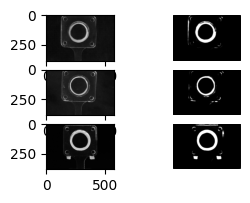

18/18 [==============================] - 2003s 112s/step - loss: 0.0217 - accuracy: 0.9582 - val_loss: 0.0322 - val_accuracy: 0.9580
Epoch 5/110
1/1 [==============================] - 1s 903ms/step


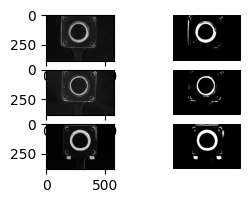

18/18 [==============================] - 2157s 121s/step - loss: 0.0202 - accuracy: 0.9584 - val_loss: 0.0329 - val_accuracy: 0.9585
Epoch 6/110
1/1 [==============================] - 1s 998ms/step


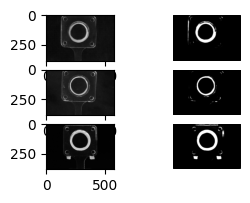

18/18 [==============================] - 2066s 115s/step - loss: 0.0202 - accuracy: 0.9584 - val_loss: 0.0272 - val_accuracy: 0.9586
Epoch 7/110
1/1 [==============================] - 1s 885ms/step


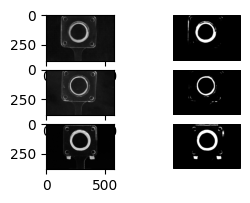

18/18 [==============================] - 2135s 119s/step - loss: 0.0201 - accuracy: 0.9581 - val_loss: 0.0271 - val_accuracy: 0.9578
Epoch 8/110
1/1 [==============================] - 1s 929ms/step


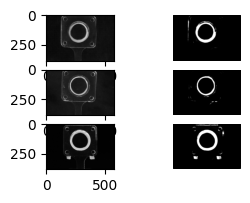

18/18 [==============================] - 2097s 117s/step - loss: 0.0198 - accuracy: 0.9582 - val_loss: 0.0256 - val_accuracy: 0.9575
Epoch 9/110
1/1 [==============================] - 1s 883ms/step


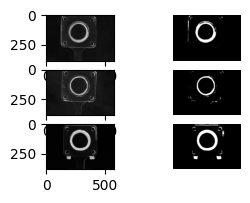

18/18 [==============================] - 2109s 116s/step - loss: 0.0199 - accuracy: 0.9601 - val_loss: 0.0268 - val_accuracy: 0.9622
Epoch 10/110
1/1 [==============================] - 1s 911ms/step


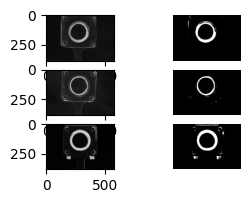

18/18 [==============================] - 2139s 119s/step - loss: 0.0192 - accuracy: 0.9649 - val_loss: 0.0248 - val_accuracy: 0.9634
Epoch 11/110
1/1 [==============================] - 1s 904ms/step


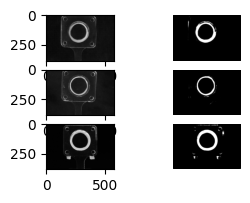

18/18 [==============================] - 2069s 115s/step - loss: 0.0196 - accuracy: 0.9647 - val_loss: 0.0246 - val_accuracy: 0.9630
Epoch 12/110
1/1 [==============================] - 1s 820ms/step


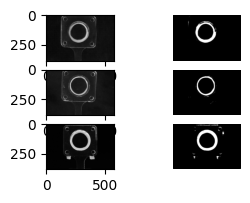

18/18 [==============================] - 2038s 113s/step - loss: 0.0191 - accuracy: 0.9646 - val_loss: 0.0239 - val_accuracy: 0.9631
Epoch 13/110
1/1 [==============================] - 1s 948ms/step


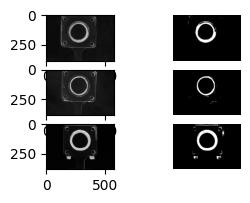


Epoch 00012: Learning rate is 0.00000100.
18/18 [==============================] - 1962s 109s/step - loss: 0.0197 - accuracy: 0.9641 - val_loss: 0.0230 - val_accuracy: 0.9643
Epoch 14/110
1/1 [==============================] - 1s 929ms/step


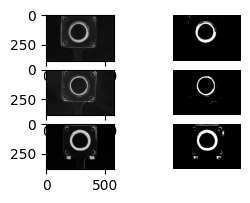

18/18 [==============================] - 2092s 116s/step - loss: 0.0190 - accuracy: 0.9648 - val_loss: 0.0238 - val_accuracy: 0.9634
Epoch 15/110
1/1 [==============================] - 1s 820ms/step


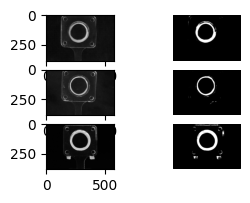

18/18 [==============================] - 2078s 115s/step - loss: 0.0194 - accuracy: 0.9644 - val_loss: 0.0237 - val_accuracy: 0.9633
Epoch 16/110
1/1 [==============================] - 1s 892ms/step


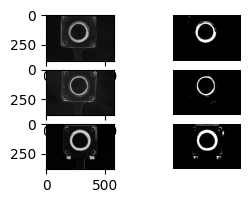


Epoch 00015: Learning rate is 0.00000100.
18/18 [==============================] - 2082s 116s/step - loss: 0.0193 - accuracy: 0.9642 - val_loss: 0.0229 - val_accuracy: 0.9640
Epoch 17/110
1/1 [==============================] - 1s 870ms/step


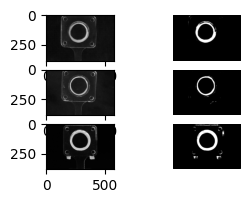

18/18 [==============================] - 2147s 119s/step - loss: 0.0191 - accuracy: 0.9646 - val_loss: 0.0237 - val_accuracy: 0.9632
Epoch 18/110
1/1 [==============================] - 1s 893ms/step


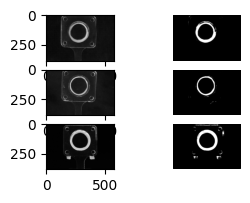

18/18 [==============================] - 2208s 123s/step - loss: 0.0192 - accuracy: 0.9646 - val_loss: 0.0232 - val_accuracy: 0.9638
Epoch 19/110
1/1 [==============================] - 1s 918ms/step


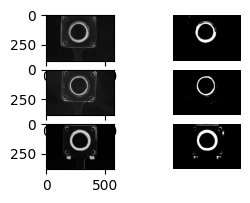

18/18 [==============================] - 2251s 125s/step - loss: 0.0192 - accuracy: 0.9645 - val_loss: 0.0232 - val_accuracy: 0.9634
Epoch 20/110
1/1 [==============================] - 1s 892ms/step


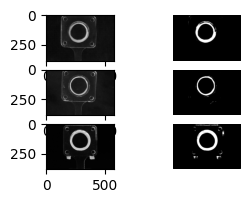

18/18 [==============================] - 2457s 137s/step - loss: 0.0194 - accuracy: 0.9641 - val_loss: 0.0234 - val_accuracy: 0.9634
Epoch 21/110
1/1 [==============================] - 1s 902ms/step


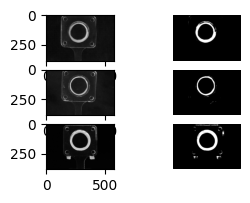

18/18 [==============================] - 2363s 138s/step - loss: 0.0193 - accuracy: 0.9644 - val_loss: 0.0231 - val_accuracy: 0.9636
Epoch 22/110
1/1 [==============================] - 1s 881ms/step


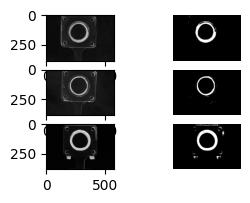

18/18 [==============================] - 2343s 130s/step - loss: 0.0193 - accuracy: 0.9644 - val_loss: 0.0237 - val_accuracy: 0.9631
Epoch 23/110
1/1 [==============================] - 1s 902ms/step


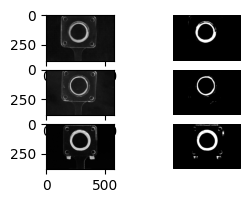

18/18 [==============================] - 2308s 130s/step - loss: 0.0192 - accuracy: 0.9644 - val_loss: 0.0233 - val_accuracy: 0.9638
Epoch 24/110
1/1 [==============================] - 1s 901ms/step


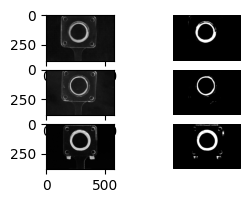


Epoch 00023: Learning rate is 0.00000100.
18/18 [==============================] - 2461s 137s/step - loss: 0.0191 - accuracy: 0.9647 - val_loss: 0.0230 - val_accuracy: 0.9637
Epoch 25/110
1/1 [==============================] - 1s 864ms/step


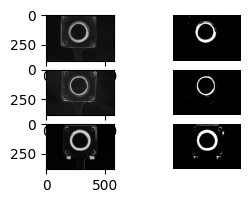

18/18 [==============================] - 2494s 139s/step - loss: 0.0190 - accuracy: 0.9648 - val_loss: 0.0233 - val_accuracy: 0.9635
Epoch 26/110
1/1 [==============================] - 1s 922ms/step


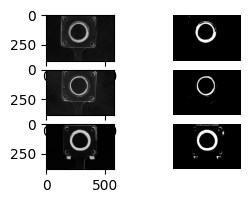

OSError: [Errno 22] Unable to extend file properly (file write failed: time = Wed Nov  1 08:18:26 2023
, filename = 'W:\Advanced Engineering\Vortex Ballistics\~ACTIVE\Python Script\models\model 10-27_Ring Mask-105 epochs-582 images/25.h5', file descriptor = 4, errno = 22, error message = 'Invalid argument', buf = 000001655A96F318, total write size = 1736, bytes this sub-write = 1736, bytes actually written = 18446744073709551615, offset = 96)

In [42]:
BUFFER_SIZE = 1000
NUM_EPOCHS = 110

TRAIN_LENGTH = 213
#STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
STEPS_PER_EPOCH = 13

VAL_SUBSPLITS = 5
TEST_LENTH = 27
#VALIDATION_STEPS = TEST_LENTH // BATCH_SIZE // VAL_SUBSPLITS
VALIDATION_STEPS = 5

#model_history = unet_model.fit(train_generator,
#                               epochs=NUM_EPOCHS,
#                               steps_per_epoch= sampleSize//BATCH_SIZE,
#                               validation_steps=VALIDATION_STEPS,
#                               validation_data=test_generator,
#                               #callbacks=[es]
#                              )

model_history = unet_model.fit(train_generator,
                               epochs=NUM_EPOCHS,
                               steps_per_epoch= sampleSize//BATCH_SIZE,
                               validation_steps=VALIDATION_STEPS,
                               validation_data=test_generator,
                               callbacks=[OutputPrinting(), EarlyStoppingAtMinLoss()]
                               )

In [ ]:
testFile = "W:\Advanced Engineering\Vortex Ballistics\Gel Images\Model Training/00- Full Image Dataset\IMG_00718.JPG"
testImg = image.load_img(testFile, color_mode='grayscale')
testImg = np.expand_dims(testImg, axis=0)
testImg = testImg/255
testImg = testImg
imOut = unet_model.predict(testImg)

1/1 [==============================] - 1s 838ms/step


[[0.28855962 0.1164763  0.05969939 ... 0.07173347 0.10290319 0.20094414]
 [0.17821263 0.04102397 0.01594463 ... 0.02102899 0.03984131 0.12504685]
 [0.13056187 0.02120915 0.00657494 ... 0.00753315 0.01650679 0.07284863]
 ...
 [0.10194948 0.03136933 0.00986462 ... 0.00147264 0.0052101  0.03973701]
 [0.13806418 0.05742769 0.02106058 ... 0.00514165 0.01591568 0.07150298]
 [0.20802203 0.10854301 0.05501487 ... 0.04210283 0.09177992 0.19517018]]


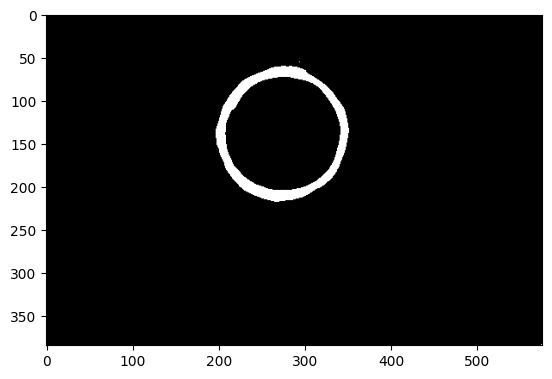

In [ ]:
imOut = imOut.reshape(testImg.shape[1:3])
print(imOut)
normalizedArr = tf.keras.utils.normalize(imOut)
predicted_mask = (normalizedArr > .104).astype(np.uint32)
plt.imshow(imOut>0.16, cmap='gray')